In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras import regularizers

import tensorflow as tf
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
# config = tf.ConfigProto(
#     gpu_options=tf.GPUOptions(
#         per_process_gpu_memory_fraction=0.1 # 最大値の50%まで
#     )
# )
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        allow_growth=True # True->必要になったら確保, False->全部
    )
)
sess = tf.Session(config=config)



train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
id_period_mapping = pd.read_csv("./data/id_period_mapping.csv")
test_data["period"] = id_period_mapping["period"]
sample_submission = pd.read_csv("./data/sample_submit.csv", header=None)
test_data.index = test_data["data_id"]

mask = (train_data["period"] == "train9") | (train_data["period"] == "train6") | (train_data["period"] == "train4") | (train_data["period"] == "train7") | \
(train_data["period"] == "train5") | (train_data["period"] == "train3") | (train_data["period"] == "train1") | (train_data["period"] == "train14") | \
(train_data["period"] == "train13") | (train_data["period"] == "train11") | (train_data["period"] == "train10") | (train_data["period"] == "train2") | \
(train_data["period"] == "train12") | (train_data["period"] == "train10") | (train_data["period"] == "train14")
train_data = train_data[mask]

train_y = train_data.iloc[:, -1]

l = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
dfx = pd.DataFrame()
for i in l:
    dfi = train_data[train_data.period == "train{}".format(i)].iloc[:, 2:90]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
train_X = dfx
dfx = pd.DataFrame()
for i in range(1, 11):
    dfi = test_data[test_data.period == "test{}".format(i)].iloc[:, 1:-1]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
test_X = dfx
test_X = test_X.loc[test_data.index]

Using TensorFlow backend.


In [2]:
concat_train_X = pd.concat([train_X, test_X])

concat_train_X = concat_train_X[["c12", "c80", "c48", "c81"]] # 0.69218 → 0.69208

#concat_train_X = concat_train_X[["c12", "c80", "c48", "c81",
#                                 "c68", "c56", "c27", "c67", "c20", "c4"]] # 0.69391

#concat_train_X = concat_train_X[["c12", "c80", "c48", "c81",
#                                 "c68", "c56", "c27", "c67"]]  0.69316	

concat_train_X = np.array(concat_train_X)

In [3]:
# import cv2
# from keras.utils.visualize_util import plot
# plot(model, to_file="model.png", show_shapes=True)
# plt.figure(figsize=(15, 15))
# plt.imshow(cv2.imread("./model.png"))

アンサンブルする場合

In [4]:
pred_list = []
for i in range(5):
    model = Sequential()
    model.add(Dense(100, input_dim=concat_train_X.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(concat_train_X.shape[1]))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    model.fit(concat_train_X, concat_train_X, nb_epoch=10, batch_size=4096)
    
    # with a Sequential model
    get_2nd_layer_output = K.function([model.layers[0].input],
                                      [model.layers[2].output])
    layer_output = get_2nd_layer_output([concat_train_X])[0]

    train_feature = layer_output[:520000, :]
    test_feature = layer_output[520000:, :]

    train_y = np.array(train_y)
    bias = np.ones(520000)
    train_feature = np.c_[train_feature, bias]
    bias = np.ones(361500)
    test_feature = np.c_[test_feature, bias]
    
    w = np.linalg.inv(train_feature.T.dot(train_feature)).dot(train_feature.T).dot(train_y)
    pred = w.dot(test_feature.T)
    pred_list.append(pred)

Epoch 1/10
881500/881500 [==============================] - 2s - loss: 0.1350 - acc: 0.9044     
Epoch 2/10
881500/881500 [==============================] - 1s - loss: 0.0031 - acc: 0.9781     
Epoch 3/10
881500/881500 [==============================] - 1s - loss: 0.0014 - acc: 0.9823     
Epoch 4/10
881500/881500 [==============================] - 1s - loss: 7.6458e-04 - acc: 0.9853     
Epoch 5/10
881500/881500 [==============================] - 1s - loss: 5.1499e-04 - acc: 0.9875     - ETA: 1s - loss: 5.6768e-04 - ETA: 0s - loss: 5.5324e-04 - acc
Epoch 6/10
881500/881500 [==============================] - 1s - loss: 3.8411e-04 - acc: 0.9891     - ETA: 0s - loss:
Epoch 7/10
881500/881500 [==============================] - 1s - loss: 3.0242e-04 - acc: 0.9904     
Epoch 8/10
881500/881500 [==============================] - 1s - loss: 2.4342e-04 - acc: 0.9914     
Epoch 9/10
881500/881500 [==============================] - 1s - loss: 1.9708e-04 - acc: 0.9923     
Epoch 10/10
881500/8815

In [5]:
sample_submission[1] = np.average(pred_list, 0)

線形回帰

## 結果確認

In [6]:
sample_submission.to_csv("result2.csv", index=0)

In [7]:
sample_submission.iloc[:, 1].mean()

0.50000203486461758

In [8]:
sample_submission[1].max()

0.66658382801978822

In [9]:
sample_submission[1].min()

0.32883757508534373

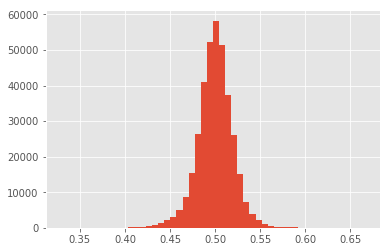

In [10]:
plt.style.use("ggplot")
plt.hist(sample_submission[1], bins=50)
plt.show()

- 4つの特徴量でアンサンブルすると精度あがる
- 線形回帰で特徴数が10とかでも、もとの4つの特徴量がよければ精度がよい


In [1]:
import numpy as np
import matplotlib.pyplot as plt

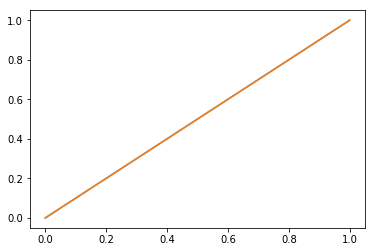

In [3]:
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.show()